# DFT calculation of He atom

In [1]:
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib as mpl
mpl.rcParams['mathtext.fontset'] = 'custom'
mpl.rcParams['mathtext.rm'] = 'Times New Roman'
mpl.rcParams['mathtext.it'] = 'Times New Roman:italic'
mpl.rcParams['mathtext.bf'] = 'Times New Roman:bold'

mpl.rc('font',family='serif',size='16')
fig = plt.figure(1,figsize=(7,5))
#fig = plt.figure(1,figsize=(7, 5)) ## To save figure.

tableau20 = [(31, 119, 180), (174, 199, 232), (255, 127, 14), (255, 187, 120),    
             (44, 160, 44), (152, 223, 138), (214, 39, 40), (255, 152, 150),    
             (148, 103, 189), (197, 176, 213), (140, 86, 75), (196, 156, 148),    
             (227, 119, 194), (247, 182, 210), (127, 127, 127), (199, 199, 199),    
             (188, 189, 34), (219, 219, 141), (23, 190, 207), (158, 218, 229)]    
  
# Scale the RGB values to the [0, 1] range, which is the format matplotlib accepts.    
for i in range(len(tableau20)):    
    r, g, b = tableau20[i]    
    tableau20[i] = (r / 255., g / 255., b / 255.) 

<Figure size 504x360 with 0 Axes>

In [2]:
import sys,os
import copy

# Numerov

## Algorithm
$$\begin{aligned}
\frac{{\rm{d}}^2 x(t)}{{\rm{d}}t^2} & = f(t) x(t) \\
x(h) + x(-h) - 2 x(0) & = h^2 f(0) x(0) + \frac{h^4}{12}x^{(4)}(0) + \mathcal{O}(h^{(6)}) \\
\end{aligned}$$

From central difference:
$$\begin{aligned}
x^{(4)} & = \frac{x^{(2)}(h)+x^{(2)}(-h) - 2 x^{(2)}(0)}{h^2} \\
\end{aligned}$$

Insert the differential equation $x'' (t)= f(t)x(t)$:

$$\begin{aligned}
x^{(4)} (0) & = \frac{x(h)f(h) + x(-h)f(-h) - 2 x(0)f(0) }{h^2} \\
\end{aligned}$$

$$\begin{aligned}
x(h) + x(-h) - 2 x(0) & = h^2 f(0) x(0) + \frac{h^2}{12} \left[
x(h)f(h) + x(-h)f(-h) - 2 x(0)f(0)
\right]+ \mathcal{O}(h^{(6)})\\ 
\left[1-\frac{h^2}{12}f(h)\right]x(h) +
\left[1-\frac{h^2}{12}f(-h)\right]x(-h) -
2 \left[1-\frac{h^2}{12}f(0)\right]x(0) & = h^2 f(0)x(0) + \mathcal{O}(h^{(6)})\\ 
\end{aligned}$$



Introduce:
$$\begin{aligned}
w(t) & = \left[1-\frac{h^2}{12}f(t)\right]x(t)\\
\end{aligned}$$

We have:
$$\begin{aligned}
\left[w(h) + w(-h) -2 w(0)\right] & = h^2 f(0)x(0) + \mathcal{O}(h^{(6)})\\
\end{aligned}$$

If $x(0)$ and $\dot{x}(0)$ is known, first we use:
$$\begin{aligned}
2h\dot{x}(0) & = \left[
1-h^2f(h)/6
\right]x(h) - 
\left[
1-h^2f(-h)/6
\right]x(-h) + \mathcal{O}(h^5) \\
\end{aligned}$$

Then:
$$\begin{aligned}
x(h) & = \frac{\left[
2+5h^2f(0)/6
\right]\left[
1-h^2f(-h)/12
\right]x(0) + 2h\dot{x}(0)\left[
1-h^2f(-h)/6
\right]}
{\left[
1-h^2f(h)/12
\right]\left[
1-h^2f(-h)/6
\right]+\left[
1-h^2f(-h)/12
\right]\left[
1-h^2f(h)/6
\right]}
\end{aligned}$$

## Working equation
$$\begin{aligned}
\ddot{\Psi}_i  & = {\bf{FArr}}_i \Psi_i \\
{\bf{FArr}}_i  & = 2(V(R_i)-E)+\frac{L(L+1)}{R^2_{i}} \\
\end{aligned}$$

## Variable list
| Variable | Meaning |
|--|:--|
PhiStart | Initial value of the solution
PhiNext | Initial+1 value of the solution
Delta  |  Integration step
StartI | Initial of integration step\* 
EndI   | Final of integration step\*
Solution | Output values. Array.
Sing   | Whether the potential contains a singularity at $r=0$\*\*.
MaxSol | The maximum number of the solution length.


* \*: If StartI $>$ EndI, the integration is performed backward.
* \*\*: If there is a singularity at $r=0$, the value of the Numerov function $w$ at $r=0$ is taken equal to **PhiStart**, and not equal to **PhiStart**$/(1-h^2 {\bf{FArr}}/12)$.

In [3]:
def Numerov(Delta, StartI, EndI, MaxSol, FArr,\
            Sing, PhiStart, PhiNext):
    '''
    This is a stand-alone subroutine. So it can be defined previously.
    C Integrates the Schrodinger equation. The initial values
    C of the solution are PhiStart and PhiNext resectively. The integration
    C step is Delta, and the integration steps run from StartI to EndI. StartI may be larger
    C than EndI; in that case, integration is performed backward.
    C The output values is the solution, stored in the array "Solution".
    C Sing determines whether the potential contains a singularity at
    C r=0.
    C If there is a singularity at r=0, the value of the Numerov
    C function w at r=0 is taken equal to PhiStart, and not
    C equal to PhiStart/(1-h^2 FArr/12).
    
    C This array is declared with linear size MaxSol.
    C Delta is the integration step.
    C The equation solved is
    C Psi''(R_I) = FArr(I) Psi(R_I)
    C FArr must therefore be filled with the appropriate values before
    C calling the present routine. In the case of the radial
    C Schrodinger equation, FArr would contain the values
    C FArr(I) = 
    '''
    Solution = np.zeros(MaxSol)
    ## print("MaxSol in Numerov: ", MaxSol)
    if (Delta<0):
        IStep = -1
    else:
        IStep = 1

    DeltaSq = Delta*Delta
    Fac = DeltaSq/12.0E0

    if (Sing):
        WPrev = PhiStart
    else:
        WPrev = (1.0-Fac*FArr[StartI-1])*PhiStart
        Solution[StartI-1] = PhiStart

    # print("StartI: ", StartI)
    # print("WPrev: ", WPrev)
    # print("IStep: ", IStep)
    Phi = PhiNext
    Solution[StartI+IStep-1] = PhiNext
    W   = (1-Fac*FArr[StartI+IStep])*Phi

    N_start = StartI+IStep-1
    N_final = EndI - IStep
    ## print("Nstart, Nfinal: ",N_start,N_final)
    for I in range(N_start, N_final, IStep):
        WNext = W*2.0E0 - WPrev + DeltaSq*Phi*FArr[I]
        WPrev = W
        W     = WNext
        Phi   = W/(1.0E0-Fac*FArr[I+IStep])
        ## print("I+IStep: ",I+IStep)
        Solution[I+IStep] = Phi
        
    return Solution

# Initialize the parameters.

In [4]:
MaxSol = 10000 ## Integer

h       =  0.01 ## Small interval in Numerov.
MaxRad  =  10.0 ## Maximum Integration Radius, r_{max}
Z       =  2.0E0  ## Nuclear Charge. For He it's 2 a.u.

MaxI    = np.int(MaxRad/h) ## Integer
MaxRad  = MaxI*h ### Double check the MaxRad.
Third   = 1.0E0/3.0E0

# CALL Initialise
OldEnergy  = -5.0E0
Energy     = -0.3E0
Precision = 1.0E-7

ChDens = np.zeros(MaxSol)

HartPot = np.zeros(MaxSol)

# Numerov for He

$$\begin{aligned}
\frac{{\rm{d}}^2 u(r)}{{\rm{d}}r^2} & = f(r)u(r) \\
f(r) & = -2 (E+ \frac{Z}{r} - V_{\rm{H}}(r)) = -2 (E+ \frac{Z}{r} - \frac{U(r)}{r}),\quad U(r) = rV_{\rm{H}}(r) \\
\end{aligned}$$

In [5]:
### Part 1, find the eigen energy of He. 
### The method is to find the energy making rR(r) to be zero at r=0.
### 1. Use Numerov method to find rR(r) from MaxRad to zero. The step is 0.1 a.u.
### 2. Refine the finding using Resolution.

def FindBound(Precision,MaxRad,MaxSol, MaxI, h, Z,HartPot):
    '''
    Find the energy of the bound state.
    The bound state is characterised as having a zero at r = 0.
    PhiMax is a function!!
    '''
    Low     = -3.0E0
    Step    = 0.1E0
    Low_new = FindStep(Low, Step,PhiMax, MaxRad,MaxSol, MaxI, h, Z,HartPot) ###
    # print("Low after FindStep: %20.10f " % (Low_new))
    Low     = Low_new
    High    = Low + Step
    NewPrec = Precision*0.1E0
    # print("High: %12.6f; NewPrec: %12.6e" % (High, NewPrec))
    Energy = Interpolate (Low, High, NewPrec, PhiMax,MaxRad,MaxSol, MaxI, h, Z,HartPot) ### Here PhiMax is an object.
    # print ("Energy in FindBound: %20.10f with precision of %12.2e" % (Energy,NewPrec))
    return Energy

def PhiMax(Energy, MaxRad,MaxSol, MaxI, h, Z, HartPot):
    FArr = FillFArr(Energy,HartPot, MaxSol,MaxI,h, Z) ## Here we need a new parameter: 
                                                      ## HartPot, to incorporate the hartree potential.
    PhiStart = MaxRad*np.exp(-Z*MaxRad) ## Defined here
    R = MaxRad - h 
    PhiNex = R*np.exp(-Z*R)             ## Defined here
    # print(FArr[0],FArr[1],FArr[2])
    RadArr = Numerov(-h, MaxI, 0, MaxSol, FArr, False, PhiStart, PhiNex)
    # print(RadArr[0],RadArr[1],RadArr[2])
    Phi_Max = 2.0E0*RadArr[1] - RadArr[2]+h*h*FArr[1]*RadArr[1]
    RadArr[0] = Phi_Max
    return Phi_Max

def FillFArr(Energy, HartPot, MaxSol,MaxI,h, Z):
    '''
    Fills the Array FArr apperaring in the radial equation
    Phi'' = FArr * Phi, with the appropriate values.
    
    '''
    ### FArr[0] is defined in outside world.
    FArr = np.zeros(MaxSol)
    # print("In FillFArr, MaxI, Energy, Z, h: ", MaxI, Energy, Z, h)
    for i in range(1, MaxI,1):
        r = i*h
        FArr[i] = -2.0E0*(Energy+(Z-HartPot[i])/r)
        # if i<4:
        #    print(FArr[i])
    return FArr
  
########################################
### Interpolation utilities.
########################################
def FindStep (MinX, Step, PhiMax,MaxRad,MaxSol,MaxI,h,Z,HartPot):
    '''
    F here is an object, a function.
    '''
    FPrev = PhiMax(MinX, MaxRad,MaxSol, MaxI, h, Z,HartPot)
    FNext = PhiMax(MinX + Step,MaxRad,MaxSol, MaxI, h, Z,HartPot)
    # print("u_1(%8.3f) = %16.6e, u_1(%8.3f)= %16.6e : " % (MinX+Step,FNext, MinX, FPrev))
    while (FNext*FPrev > 0):
        MinX = MinX + Step
        FNext = PhiMax(MinX+Step,MaxRad,MaxSol, MaxI, h, Z, HartPot)
        # print("u_1(%8.3f) = %16.6e " % (MinX,FNext))
    return MinX


def Interpolate (MinX, MaxX, IntWidth, PhiMax,MaxRad,MaxSol, MaxI, h, Z,HartPot):
    LeftX    = MinX
    RightX   = MaxX
    LeftRes  = PhiMax(MinX,MaxRad,MaxSol, MaxI, h, Z,HartPot)
    RightRes = PhiMax(MaxX,MaxRad,MaxSol, MaxI, h, Z,HartPot)
    MidRes = 1.0E0
    # print("In Interpolate: %8.3f %8.3f %12.6f %12.6f" %(LeftX,RightX,LeftRes,RightRes))
    # print("IntWidth: ",IntWidth)
    jj = 0
    while (np.abs(MidRes)> IntWidth):
        jj += 1
        MidX = (RightX*LeftRes-LeftX*RightRes)/(LeftRes-RightRes)
        MidRes = PhiMax(MidX,MaxRad,MaxSol, MaxI, h, Z,HartPot)

        if (MidRes*LeftRes>0.0):
            LeftRes = MidRes
            LeftX = MidX
        else:
            RightRes = MidRes
            RightX = MidX
        # print("jj: %5d, MidRes: %12.6e" % (jj, MidRes))
        if jj > 100:
            sys.exit()
    IntX = MidX
    return IntX

# Calculation of Hartree potential

The Hartree potential is defined as:
$$\begin{aligned}
V_{\rm{H}}(\boldsymbol{r}) & = \int {\rm{d}}\boldsymbol{r}' \, \frac{n(\boldsymbol{r}')}{\vert \boldsymbol{r}- \boldsymbol{r}'\vert}
\end{aligned}$$

It contains self interaction so that we do not call it Coulomb potential.
Rather than directly calculate the integration using density, we use the well-known relation in classical  electrodynamics:
$$\begin{aligned}
\nabla^2 \frac{1}{r} = -4\pi \delta{(\boldsymbol{r})} \\
\end{aligned}$$

So:
$$\begin{aligned}
\nabla^2 V_{\rm{H}}(\boldsymbol{r}) & =  \int {\rm{d}}\boldsymbol{r}' \, n(\boldsymbol{r}')\left[\nabla^2_{r} \frac{1}{\vert \boldsymbol{r}- \boldsymbol{r}'\vert}\right] = -4\pi n(\boldsymbol{r}) \\
\end{aligned}$$

Again using the same trick as $u(r) = rR(r)$, we define a new potential
$$\begin{aligned}
U(r) = rV_{\rm{H}}(r) \\
\end{aligned}$$

We have the differential equation ready for being solved by Numerov method:
$$\begin{aligned}
\frac{{\rm{d}}^2 U(r)}{{\rm{d}}r^2} = -4\pi r n(r)= 
-4\pi r R^2(r) = -4\pi r \frac{u^2(r)}{r^2} = -4\pi \frac{u^2(r)}{r} \\
\end{aligned}$$

So, we can perform Numerov method again for obtaining $V_{\rm{H}}(r)$.

Here the form of Numerov is inhomogeneous ODE:
$$\left\{\begin{aligned}
& \frac{{\rm{d}}^2 U(r)}{{\rm{d}}r^2} = f(r) \\
& f(r) = -4\pi r n(r) \\
\end{aligned}
\right.$$
The working formula can be derived as:
$$\begin{aligned}
x(t+h) + x(t-h) - 2 x(t) & = h^2 f(t)  + \frac{h^2}{12} \left[
f(t+h) + f(t-h) - 2 f(t)
\right]+ \mathcal{O}(h^{(6)})\\ 
\left[x(t+h)-\frac{h^2}{12}f(t+h)\right] +
\left[x(t-h)-\frac{h^2}{12}f(t-h)\right] -
2 \left[x(t)-\frac{h^2}{12}f(t)\right] & = h^2 f(t) + \mathcal{O}(h^{(6)})\\ 
\end{aligned}$$
Let:
$$\begin{aligned}
w'(t) & = x(t)-\frac{h^2}{12}f(t) \\
\end{aligned}$$
$$\begin{aligned}
x(t-h) & = 2w'(t) - w'(t+h) + h^2 f(t) + \frac{h^2}{12}f(t-h) \\
\end{aligned}$$

An extra trick is this Hartree potential is long range, so we need to use a switch part, ensuring it becomes $Z/r$ at long range. 

$$\begin{aligned}
Z_{\rm{Scr}} & = 1-(r^2_{\rm{max}}+2r_{\rm{max}}+1)e^{-r_{\rm{max}}} \\
{\rm{HartPot}}_i & = U(r_i) = r_{i}V_{\rm{H}}(r_i) \\
\alpha & = \frac{(Z_{\rm{Scr}}-{\rm{HartPot}}_{\rm{MaxI}})}{({\rm{MaxI}}-1)} \\
{\rm{HartPot}}_{i} & = {\rm{HartPot}}_{i} + \alpha\times (i-1),\quad i=1,2,\cdots,{\rm{MaxI}} \\
\end{aligned}$$

Finally, we need to make sure the wave function fulfills the normalization condition:

$$\begin{aligned}
\int {\rm{d}} r\,  u^2(r) & = \int {\rm{d}} r\,  \left[r^2 R^2(r)\right] = 1 \\
\end{aligned}$$

The $U(r)$ also needs to fulfill the boundary condisitons:
$$\begin{aligned}
U(0) & = \lim_{r\to 0} rV_{\rm{H}}(r) = 0 \\
V'_{\rm{H}}(r) & =\frac{ q_{\rm{max}}}{r^2} \\
q_{\rm{max}} & = \int_{0}^{r_{\rm{max}}} {\rm{d}}r\, u^2(r) \\
\end{aligned}$$


In [6]:
### Later steps. SolveRad is to find 
### the density (-4*Pi*r*n(r) actually) for next step usage.
### CalcHartPot is to construct Hartree potential with density.

def SolveRad(Energy,ChDens,MaxSol,MaxI,h,Z,HartPot):
    '''
    Solve the radial Schrodinger equation
    The solution is used to determine the charge density
    
    This is the 2nd major subroutine.
    '''
    # plt.plot(HartPot[:MaxI])
    # plt.show()
    # print(HartPot[:4])
    FArr = FillFArr(Energy,HartPot, MaxSol,MaxI,h, Z) ## Pay attention to HartPot!
    PhiStart = MaxRad*np.exp(-Z*MaxRad)
    R = MaxRad-h
    PhiNext = R*np.exp(-Z*R)
    
    RadArr = Numerov (-h, MaxI, 0, MaxSol, FArr, False, PhiStart,PhiNext)
    RadArr[0] = 2*RadArr[1]-RadArr[2]+h*h*FArr[1]*RadArr[1]
    # print("RadArr:")
    # print(RadArr[:4])
    # print("Finished RadArr.")
    ## Now we have obtained the Radial wave function u(r)=rR(r).
    
    for I in range(MaxI):
        ChDens[I] = RadArr[I]**2

    NormFac = CalcInt(ChDens, MaxI, h)

    NormFac = 1.0E0/NormFac
    # print ("NormFac: %12.6f" % (NormFac))
    ChDens[0] = 0.0E0 ## Since at the origin point r=0, the equation is singular...
    for I in range(1,MaxI,1):
        R = I*h
        ChDens[I] = -NormFac*ChDens[I]/R
#### Note that ChDens is in fact -n(r)*r*4*pi !!
    # print(ChDens[:4])
    return Energy, ChDens

def CalcHartPot(MaxRad,MaxSol,MaxI,h,ChDens):
    '''
    C Calculate the hartree potential. This is done by radially integrating
    C Poisson's equation. The correct boundary equations are met by starting
    C at Vh(0) = 0, and by adding the homegeneous solution alpha x r to the result
    C in order to fix the potential at MaxRad to Z/r.
    C The charge ZScr is that part of the charge of the screening
    C electron which lies in the sphere with radius
    C MaxRad (this charge must be close to 1 if MaxRad is large).
    C Note that HartPot is r x potential
    
    In major subroutine:
    Delta = h
    L = 0
    StartR = 0.0
    MaxR = MaxRad
    ZeroSing = False
    PhiStart = 0.0
    PhiNext = h
    RHS = ChDens
    MaxSol = MaxSol 
    
    Output is the array HartPot.
    '''
    HartPot = NumInhom (h, 0, 0.0E0, MaxRad, False,0.0E0,h,ChDens, MaxSol)
        
    ZScr = 1.0E0-(MaxRad*MaxRad+2*MaxRad+1.0E0)*np.exp(-MaxRad)
    Alpha = (ZScr-HartPot[MaxI])/(MaxI-1)
    
    for I in range(MaxI):
        HartPot[I] = HartPot[I]+Alpha*I
    # print(HartPot[:4])
    return HartPot

def HartCorrect(HartPot, ChDens, MaxI, h):
    '''
    C Calculate 
    \int d^r r^2 V_h(r) n (r) , 
    which is needed in the calculation of the energy.
    '''
    TempArr = np.zeros(MaxI)
    for i in range(MaxI):
        TempArr[i] = - HartPot[i]*ChDens[i]

    HartCorr = CalcInt(TempArr, MaxI, h)
    
    return HartCorr
    
def CalcInt (Array, MaxI, h):
    '''
    Calculate an integral over the radial coordinate grid. A fourth-order
    integration method is used.
    '''
    Help = (Array[0]*17.0E0+Array[1]*59.0E0+\
            Array[2]*43.0E0+Array[3]*49.0E0)/48.0E0
    for i in range(4,MaxI-4):
        Help = Help + Array[i]

    Help = (Array[MaxI-1]*17.0E0+Array[MaxI-2]*59.0E0+\
            Array[MaxI-3]*43.0E0+Array[MaxI-4]*49.0E0)/48.0E0+\
            Help
    Result = Help * h
    return Result

def NumInhom (Delta, L, StartR, MaxR, ZeroSing, PhiStart, PhiNext, RHS, MaxSol):
    '''
    Integrates an inhomogeneous the Schrodinger equation from ‘StartR’ to ‘MaxR’. 
    The initial values of the solution are PhiStart and PhiNext resectively.
    MaxR is also output as the value nearest to MaxR which is an integer
    C times the integration step from StartR.
    The output value is the solution, stored in the array "Solution".
    C This array is declared with linear size MaxSol.
    C Delta is the integration step. L is the angular momentum quantum number,
    C which is passed to the function F(R,L,E) which returns
    C F(R,L) = V(R)-E+h^2 L(L+1)/(2MR^2)
    '''

    Solution = np.zeros(MaxSol)
    
    MaxI = np.int((MaxR-StartR)/Delta)
    
    
    if (MaxSol<MaxI):
        print(MaxI, ' integration points')
        print('Size of array Solution not large enough')
        print('Program stopped in routine Numerov')
        sys.exit()
        
    DeltaSq = Delta*Delta
    Fac = DeltaSq/12.0E0

    R  = StartR
    if (ZeroSing):
        WPrev = PhiStart
        Solution[0] = 0.0E0
    else:
        WPrev = PhiStart-Fac*RHS[0] ### In stream, RHS[0] = ChDens[0]
        Solution[0] = PhiStart


    R  = StartR+Delta
    Phi = PhiNext
    Solution[1] = PhiNext
    W   = Phi-Fac*RHS[1]
    # print("W in NumInhom: %12.6f" % (W))
    #   DO I = 2, MaxI+1
    for i in range(1, MaxI+1):
        #print(rhs[i])
        WNext = W*2.0E0 - WPrev + DeltaSq*RHS[i]
        WPrev = W
        W     = WNext
        R = R + Delta
        Phi   = W+Fac*RHS[i+1]
        Solution[i+1] = Phi
        # print("%8d RHS, WNext and Phi in NumInhom: %12.6f %12.6f | %12.6f" % (i+1, RHS[i], WNext, Phi))
    MaxR = R-Delta
    PhiRNext = Phi
    PhiRMax = WPrev+Fac*RHS[MaxI]
    
    return Solution #, MaxR, PhiRNext, PhiRMax

-1.9999995967451258
Energy after SolveRad:  -1.9999995967451258
    0.000000    -0.307451    -0.590792    -0.851441
Eigenvalue -1.9999995967451258
total energy -3.9999991934902517
Finish a loop.
-0.820229996219211
Energy after SolveRad:  -0.820229996219211
    0.000000    -0.192196    -0.369459    -0.532647
Eigenvalue -0.820229996219211
total energy -2.7277806113461454
Finish a loop.
-0.9508284489977273
Energy after SolveRad:  -0.9508284489977273
    0.000000    -0.224486    -0.431467    -0.621966
Eigenvalue -0.9508284489977273
total energy -2.903498973927815
Finish a loop.
-0.9085357253775378
Energy after SolveRad:  -0.9085357253775378
    0.000000    -0.214848    -0.412952    -0.595294
Eigenvalue -0.9085357253775378
total energy -2.8494653869085904
Finish a loop.
-0.9205693190597225
Energy after SolveRad:  -0.9205693190597225
    0.000000    -0.217666    -0.418366    -0.603093
Eigenvalue -0.9205693190597225
total energy -2.86507873401085
Finish a loop.
-0.9170002473703021
Energy afte

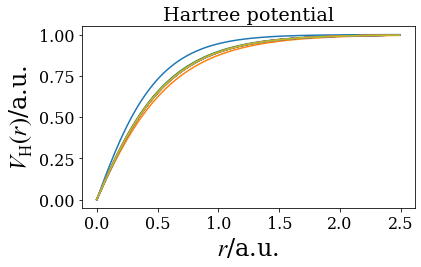

In [16]:
# Self-consistency loop:
#       DO WHILE(ABS(OldEnergy-Energy).GT.Precision)
#         OldEnergy = Energy
#         CALL FindBound(Energy, Precision)
#         CALL SolveRad(Energy)
#         CALL HartCorrect
#         print *, 'Eigenvalue', Energy
#         print *, 'total energy',2*Energy-HartCorr
#         CALL CalcHartPot
#       END DO
MaxSol = 10000 ## Integer

h       =  0.01 ## Small interval in Numerov.
MaxRad  =  10.0 ## Maximum Integration Radius, r_{max}
Z       =  2.0E0  ## Nuclear Charge. For He it's 2 a.u.

MaxI    = np.int(MaxRad/h) ## Integer
MaxRad  = MaxI*h ### Double check the MaxRad.
Third   = 1.0E0/3.0E0

# CALL Initialise
OldEnergy  = -5.0E0
Energy     = -0.3E0
Precision = 1.0E-7

ChDens = np.zeros(MaxSol)
HartPot = np.zeros(MaxSol)

x_forplot = np.arange(0.0,MaxI*h,h)
ene_traj = []
MaxI_forplot = np.int(MaxI/4)
for kk in range(20):
    OldEnergy = Energy
    Energy = FindBound(Precision,MaxRad,MaxSol, MaxI, h, Z,HartPot)
    print (Energy)
    Energy, ChDens = SolveRad(Energy,ChDens,MaxSol,MaxI,h,Z,HartPot)
    print ("Energy after SolveRad: ", Energy)
    print('%12.6f %12.6f %12.6f %12.6f' %(ChDens[0],ChDens[1],ChDens[2],ChDens[3]))
    if kk>0:
        plt.plot(x_forplot[:MaxI_forplot],HartPot[:MaxI_forplot])
    HartCorr = HartCorrect(HartPot, ChDens, MaxI, h)
    print ('Eigenvalue', Energy)
    print ('total energy',2*Energy-HartCorr)
    ene_traj.append(2*Energy-HartCorr)
    HartPot = CalcHartPot(MaxRad,MaxSol,MaxI,h,ChDens)
    print ("Finish a loop.")
    
plt.title("Hartree potential")
plt.xlabel(r"$r$/a.u.",fontsize=24)
plt.ylabel(r"$V_{\rm{H}}(r)$/a.u.",fontsize=24)
figname = 'Hartree_pot.png'
plt.tight_layout()
plt.savefig(figname,dpi=300,format = 'png')
plt.show()

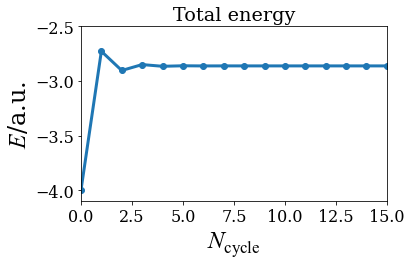

In [21]:
plt.plot(ene_traj,'o-',lw=3)
plt.title("Total energy")

plt.xlabel(r"$N_{\rm{cycle}}$",fontsize=24)
plt.ylabel(r"$E$/a.u.",fontsize=24)
figname = 'Tot_ene_He_DFT.png'
plt.axis([0,15,-4.1,-2.5])
plt.tight_layout()
plt.savefig(figname,dpi=300,format = 'png')
plt.show()